/usr/local/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in greater
/usr/local/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:146: RuntimeWarning: Mean of empty slice


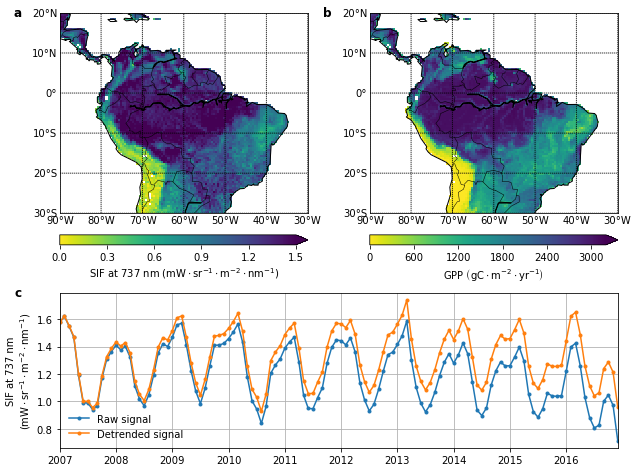

In [61]:
"""
Title: Amazon SIF and GPP
Author: Gerbrand Koren
Date: February 18th, 2018
"""

#################################################
#                                               #
# INITIALIZE                                    #
#                                               #
################################################# 

# -- IPython settings
%reset -f
%matplotlib inline

# -- Import statements
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.image as image
import netCDF4 as nc
import pandas as pd
from mpl_toolkits.basemap import Basemap
from matplotlib.gridspec import GridSpec
import sys
import pickle

# -- Import custom functions
lib_path = '../../Library'
if not sys.path.count(lib_path):
    sys.path.insert(len(sys.path),lib_path)
import pyfunc as pf

# -- Output settings
save = False

#################################################
#                                               #
# INPUT                                         #
#                                               #
################################################# 

# ==== SIF

# -- Dimensions
SIF_ntime = 120 # -
SIF_nlat = 360 # -
SIF_nlon = 720 # -

# -- Directory
SIF_path = '/home/chronos/user/Downloads/180313_MONTHLY_SIFTER/'

#################################################
#                                               #
# DATA IMPORT                                   #
#                                               #
#################################################

# ==== AMAZON MASK

# -- Load Amazon mask
f = nc.Dataset('amazon_mask.nc')
amazon = f.variables['regionmask'][:] # [latitude, longitude]
f.close()

# ==== GPP

# -- Load GPP variable
h = nc.Dataset('GPPdata_Beer_etal_2010_Science.nc')
GPP = h.variables['gpp'][:] # [latitude, longitude]
h.close()

# ==== SIF

# -- Declare variables 
SIF_filenames = []

# -- Loop over years
for year in np.arange(10)+2007:
    
    # -- Loop over months
    for month in np.arange(12)+1:
        
        # -- Construct filenames        
        SIF_filenames.append('version_25_irr_corr_'+str(year)+'_l3_'+str(month).zfill(2)+'_'+str(year)+'.nc')
        
# -- Clear loop indices
del year, month

# -- Pre-allocation
SIF = np.zeros([SIF_ntime,SIF_nlat,SIF_nlon]) # W/sr/m2/nm

# -- Loop over files
for ii in np.arange(SIF_ntime):
    
    # -- Load SIF
    h = nc.Dataset(SIF_path+SIF_filenames[ii])
    SIF[ii,:,:] = h.variables['Chl_F_monthly_v2'][:] # [time, latitude, longitude]
    h.close()
    
# -- Clear loop index        
del ii

#################################################
#                                               #
# CALCULATION                                   #
#                                               #
#################################################

# ==== GPP

# -- Convert to NumPy array
GPP = np.array(GPP) # gC/m2/yr
GPP[GPP==-9999] = -0.1 # gC/m2/yr

# -- Select color norm
GPP_norm = colors.Normalize(vmin=0.0,vmax=3200.0)

# ==== SIF

# -- Convert unit
SIF = SIF*1.0e3 # mW/sr/m2/nm

# -- Determine cell weight
cell_weight = pf.area_weighted(np.ones([SIF_nlat,SIF_nlon])) # -

# -- Increase resolution
amazon = pf.increase_resolution(amazon,SIF_nlat,SIF_nlon) # -
 
# -- Determine Amazon SIF time series
SIF_amazon = np.zeros([SIF_ntime]) # [time]
for ii in np.arange(SIF_ntime):
    SIF_amazon[ii] = np.nansum(SIF[ii,:,:]*cell_weight*amazon)/(np.sum((1-np.isnan(SIF[ii,:,:]))*cell_weight*amazon)) # W/sr/m2/nm
del ii

# -- Detrended Amazon SIF time series
[slope,offset] = np.polyfit(np.arange(SIF_ntime),SIF_amazon,1) # [slope, offset]
SIF_amazon_dtd = SIF_amazon-slope*np.arange(SIF_ntime) # W/sr/m2/nm

# -- Determine multi-year mean detrended SIF
SIF_mean = np.zeros([SIF_nlat,SIF_nlon]) # [latitude, longitude]
for ii in np.arange(SIF_nlat):
    for jj in np.arange(SIF_nlon):
        SIF_mean[ii,jj] = np.nanmean(SIF[:,ii,jj]-slope*np.arange(SIF_ntime)) # W/sr/m2/nm 
del ii, jj

# -- Apply land-mask to SIF
land_mask = (GPP>-0.1) # -
SIF_mean = SIF_mean*land_mask # W/sr/m2/nm
SIF_mean[land_mask==False] = -0.1 # W/sr/m2/nm

# -- Select color norm
SIF_norm = colors.Normalize(vmin=0.0,vmax=1.5)

#################################################
#                                               #
# RESULTS                                       #
#                                               #
################################################# 

# -- Set font settings
plt.rcParams['mathtext.default'] = 'regular'

# -- Create figure
fig = plt.figure(figsize=[10,8])
gs = GridSpec(2,2,width_ratios=[1,1],height_ratios=[1.5,1])
gs.update(wspace=0.25,hspace=0.25)

# -- Plot global SIF
ax1 = fig.add_subplot(gs[0,0])
m = Basemap(projection='cyl',llcrnrlat=-30,urcrnrlat=20,llcrnrlon=-90,urcrnrlon=-30,fix_aspect=False)
im = m.imshow(SIF_mean[120:220,180:300],interpolation='none',norm=SIF_norm,cmap='viridis_r')
im.cmap.set_under('white')
m.drawcoastlines()
m.drawcountries()
parallels = np.linspace(-90.,90.,19)
m.drawparallels(parallels,labels=[True,False,False,False])
meridians = np.linspace(0.,360.,37)
m.drawmeridians(meridians,labels=[False,False,False,True])
cbar1 = m.colorbar(location='bottom',pad=0.3,extend='max',label=r'SIF at 737 nm $\left(mW\cdot sr^{-1}\cdot m^{-2}\cdot nm^{-1}\right)$')
cbar1.set_ticks([0,0.3,0.6,0.9,1.2,1.5])
ax1.text(-0.17,1.0,'a',transform=ax1.transAxes,va='center',ha='center',weight='bold',size='large')

# -- Plot global GPP
ax2 = fig.add_subplot(gs[0,1])
m = Basemap(projection='cyl',llcrnrlat=-30,urcrnrlat=20,llcrnrlon=-90,urcrnrlon=-30,fix_aspect=False)
im = m.imshow(GPP[120:220,180:300],interpolation='none',norm=GPP_norm,cmap='viridis_r')
im.cmap.set_under('white')
m.drawcoastlines()
m.drawcountries()
parallels = np.linspace(-90.,90.,19)
m.drawparallels(parallels,labels=[True,False,False,False])
meridians = np.linspace(0.,360.,37)
m.drawmeridians(meridians,labels=[False,False,False,True])
cbar2 = m.colorbar(location='bottom',pad=0.3,extend='max',label=r'GPP $\left(gC\cdot m^{-2}\cdot yr^{-1}\right)$')
cbar2.set_ticks([0,600,1200,1800,2400,3000])
ax2.text(-0.17,1.0,'b',transform=ax2.transAxes,va='center',ha='center',weight='bold',size='large')

# -- Time series
ax3 = fig.add_subplot(gs[1,:])
plt.plot(np.arange(SIF_ntime),SIF_amazon,'.-',label='Raw signal')
plt.plot(np.arange(SIF_ntime),SIF_amazon_dtd,'.-',label='Detrended signal')
plt.xlim(0,SIF_ntime-1)
plt.xticks([0,12,24,36,48,60,72,84,96,108],
           ['2007','2008','2009','2010','2011','2012','2013','2014','2015','2016'])
plt.ylabel('SIF at 737 nm\n'+r'$\left(mW\cdot sr^{-1}\cdot m^{-2}\cdot nm^{-1}\right)$')
plt.legend(frameon=False)
plt.grid(True)
ax3.text(-0.075,1.0,'c',transform=ax3.transAxes,va='center',ha='center',weight='bold',size='large')

# -- Save figure
if save == True:
    plt.savefig('Fig1.pdf',dpi=300,bbox_inches='tight')
else:
    plt.show()